In [1]:
import pandas as pd
import numpy as np
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Structure for the data

```
[{'product/productId': 'B000JVER7W',
  'product/title': 'Mobile Action MA730 Handset Manager - Bluetooth Data Suite',
  'product/price': 'unknown'...],...
```

In [2]:
def preprocess_cell_phones_data(filename):
    """
    Preprocesses data from a text file containing cell phone records.

    Args:
    filename (str): The path to the text file containing the cell phone records.

    Returns:
    list: A list of dictionaries, where each dictionary represents a single cell phone record.
          Each dictionary contains key-value pairs corresponding to the attributes of the cell phone record.
    """
    all_records = []
    single_record = {}
    

    with open(filename, 'r') as file:
        lines = file.readlines()

        for line in lines:
            # Split the line by colon
            line = line.split(':')

            # Check if the first element is not an empty string
            if line[0].strip():
                # Add key-value pair to single_record dictionary
                single_record[line[0].strip()] = line[1].strip()
                
                # Check if the attribute is 'review/text'
                if line[0].strip() == 'review/text':
                    # Append single_record to all_records list and reset single_record
                    all_records.append(single_record)
                    single_record = {}

    return all_records


In [3]:
# Get data from file and preprocess it
samples = preprocess_cell_phones_data('/Users/sirajshaikh/Downloads/dataset_2.txt')
len(samples)

78930

## Convert dataframe to csv

In [4]:
data = pd.DataFrame(samples)

## Feature engineering

                                                                   Score count  \
product/title                                      PriceIntervals                
Standard Lithium-Ion Battery (850mAh) for Sanyo... 0-10                     41   
Nokia OEM CA-53 USB data cable for Nokia 3300 6... 0-10                     32   
Motorola Right Angle Charger Adapter Mini-USB -... 0-10                     34   
Multi-Use Vehicle Charger with Dual USB Ports a... 26-50                   145   
Plantronics CS50 Battery                           26-50                    40   
PalmOne m100 series Faceplate Cover (Blue Mist)    0-10                    236   
PalmOne m100 series Faceplate Cover (Silver Mist)  0-10                     59   
BoxWave Motorola Photon 4G DuoSuit - Slim-Fit U... 11-25                    37   
Motorola Car Charger for A630, T720, T730, V300... 0-10                     36   
Krusell Classic with Multidapt Leather Case for... 0-10                     35   

               

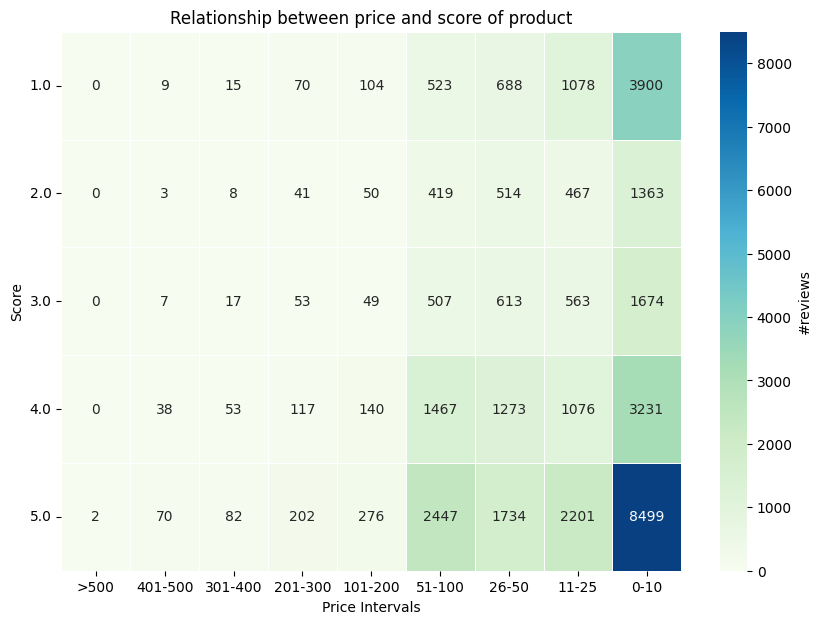

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data.csv', delimiter=',')
data = data[data['product/price'] != 'unknown']
# Define price intervals based on product price
price_intervals = ['0-10', '11-25', '26-50', '51-100', '101-200', '201-300', '301-400', '401-500', '>500']
data['PriceIntervals'] = pd.cut(data['product/price'].astype(float), 
                                 bins=[0, 10, 25, 50, 100, 200, 300, 400, 500, float('inf')], 
                                 labels=price_intervals)

# Group data by review score and price intervals, and aggregate with count
df = data.groupby(['review/score', 'PriceIntervals']).size().unstack()

# Sort the columns based on the predefined order of price intervals
df = df[price_intervals[::-1]]

# Plot the heatmap
fig = plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap='GnBu', linewidths=.5, fmt='.0f', annot=True, cbar_kws={'label': '#reviews'})
plt.yticks(rotation=0)
plt.title('Relationship between price and score of product')
plt.xlabel('Price Intervals')
plt.ylabel('Score')
plt.savefig('Price-score.png')

# Group data by product title and price intervals, and aggregate with count and mean score
data_rec = data.groupby(['product/title', 'PriceIntervals']).agg({'review/score': ['count', 'mean']})
data_rec.columns = data_rec.columns.get_level_values(1)
data_rec.columns = ['Score count', 'Score mean']

# Filter the data where the score count is greater than 30 and sort by mean score
data_user = data_rec[data_rec['Score count'] > 30].sort_values(by='Score mean', ascending=False)
print(data_user.head(10));


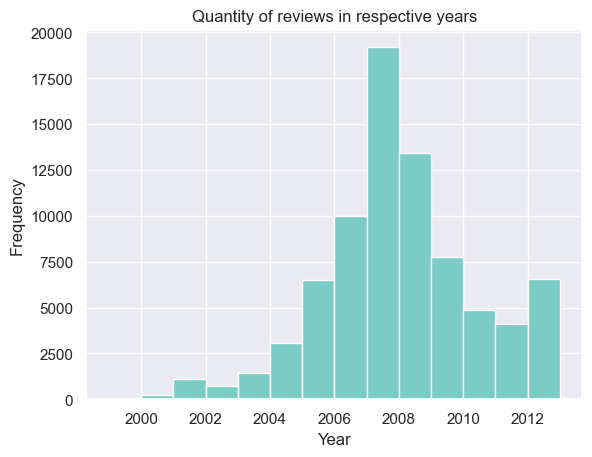

In [10]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns


times = []
data = pd.read_csv('data.csv', delimiter=',')
for i in range(0, len(data)):
    readable = time.ctime(data['review/time'][i])
    times.append(int(readable[-4:]))

data['year'] = times

sns.set()
colors = sns.color_palette("GnBu", 1)
data['year'].plot.hist(bins = 14, rwidth = 1, color = colors)
plt.xlabel('Year')
plt.title('Quantity of reviews in respective years')
plt.savefig('Time-score.png')

## Word Analysis

In [1]:
# Importing pandas library with alias pd
import pandas as pd

# Importing CountVectorizer and TfidfVectorizer from sklearn's feature_extraction.text module
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing LogisticRegression and train_test_split from sklearn's linear_model and model_selection modules, respectively
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Reading data from a CSV file named 'data.csv' into a pandas DataFrame
data = pd.read_csv('data.csv', delimiter=',')

# Filtering out rows where the 'review/score' column is not equal to 3
df = data[data['review/score'] != 3]

# Extracting the 'review/text' column from the filtered DataFrame as feature (X)
X = df['review/text']

# Mapping the review scores to binary labels (0 for negative, 1 for positive)
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['review/score'].map(y_dict)

# Defining a function called word_analysis that takes X, y, model, and clf_model as input parameters
def word_analysis(X, y, model, clf_model):
    # Transforming the input text data into a matrix representation using the provided model
    X_m = model.fit_transform(X)
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_m, y, random_state=0)
    
    # Fitting the classifier model on the training data
    clf = clf_model.fit(X_train, y_train)
    
    # Evaluating the model accuracy on the test data
    ACU = clf.score(X_test, y_test)
    print('Model Accuracy: {}'.format(ACU))

    # Checking the type of vectorizer used and getting feature names accordingly
    if isinstance(model, CountVectorizer):
        feature_names = model.get_feature_names_out()
    elif isinstance(model, TfidfVectorizer):
        feature_names = model.get_feature_names_out()
    else:
        raise ValueError("Model type not supported")

    # Getting coefficients from the classifier model and creating a DataFrame to display them
    coef = clf.coef_.tolist()[0]
    coeff_df = pd.DataFrame({'Word': feature_names, 'Coefficient': coef})
    coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
    
    # Printing top 20 positive and negative coefficients
    print('')
    print('-Top 20 positive-')
    print(coeff_df.head(20).to_string(index=False))
    print('')
    print('-Top 20 negative-')
    print(coeff_df.tail(20).to_string(index=False))

# Creating CountVectorizer and TfidfVectorizer objects with stop words removed
c = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

# Calling the word_analysis function with TF-IDF vectorizer and Logistic Regression classifier
word_analysis(X, y, tfidf, LogisticRegression(max_iter=200))


Model Accuracy: 0.8801344499515752

-Top 20 positive-
     Word  Coefficient
    great    10.095370
     love     7.922485
excellent     7.418927
     best     7.154730
    works     6.934949
  perfect     6.826612
     easy     6.473330
perfectly     6.468917
   highly     5.518681
  pleased     4.963868
  awesome     4.831057
   little     4.464605
  amazing     4.318426
    price     4.310787
satisfied     4.256013
    clear     4.246294
    happy     4.203432
      far     4.153500
      job     4.089248
  overall     3.949104

-Top 20 negative-
         Word  Coefficient
       unless    -3.934104
        broke    -4.080214
    worthless    -4.089403
         stay    -4.187053
       poorly    -4.245154
    returning    -4.643676
       refund    -4.752192
        worse    -4.830592
unfortunately    -4.959345
         junk    -5.096468
       return    -5.190240
      stopped    -5.209394
     terrible    -5.694538
     horrible    -5.889946
     returned    -6.020002
 disappointe

## Price Plot

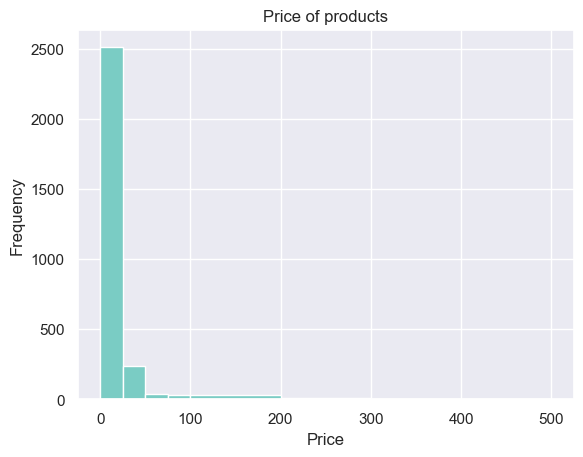

In [12]:
df = data.drop_duplicates('product/productId', inplace=False)
df1 = df[df['product/price'] != 'unknown']

sns.set()
colors = sns.color_palette("GnBu", 1)
b = [0,25,50,75,100,200,300,400,500]
df1['product/price'].astype('float64').plot.hist(bins = b, rwidth = 1, color = colors)
plt.xlabel('Price')
plt.title('Price of products')
plt.savefig('Price of products.png')

In [2]:
import re  # Importing the regular expression module for string manipulation
from nltk.corpus import stopwords  # Importing stopwords from NLTK corpus

def review_to_wordlist(plots):
    """
    Converts a review text into a list of words after cleaning and tokenizing.

    Args:
    - plots (str): The review text to be processed.

    Returns:
    - list: A list of words extracted from the review text.
    """
    # Remove non-alphabetic characters and replace with space
    review_text = re.sub("[^a-zA-Z]", " ", plots)
    
    # Convert text to lowercase and split into words
    words = review_text.lower().split()
    
    # Remove stopwords from the word list
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]

    return words


def review_to_sentences_list(plots, tokenizer):
    """
    Converts a review text into a list of sentences, where each sentence is represented as a list of words.

    Args:
    - plots (str): The review text to be processed.
    - tokenizer: A tokenizer object for splitting text into sentences.

    Returns:
    - list: A list of sentences, where each sentence is represented as a list of words.
    """
    # Tokenize the review text into sentences
    raw_sentences = tokenizer.tokenize(plots.strip())
    
    # Initialize an empty list to store sentences
    sentences = []
    
    # Process each raw sentence
    for raw_sentence in raw_sentences:
        # Check if the sentence is not empty
        if len(raw_sentence) > 0:
            # Convert the raw sentence into a list of words
            sentences.append(review_to_wordlist(raw_sentence))

    return sentences


def review_to_wordsentence(reviews):
    """
    Converts a list of review texts into a list of word lists.

    Args:
    - reviews (list): A list of review texts.

    Returns:
    - list: A list of word lists, where each word list represents a review.
    """
    # Initialize an empty list to store word lists
    word_lists = []
    
    # Process each review text
    for review in reviews:
        # Remove non-alphabetic characters and replace with space
        review_text = re.sub("[^a-zA-Z]", " ", review)
        
        # Convert text to lowercase and split into words
        words = review_text.lower().split()
        
        # Remove stopwords from the word list
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
        # Append the processed word list to the main list
        word_lists.append(words)

    return word_lists


In [14]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [15]:
# Tokenize the reviews into sentences and lowercase each sentence
sentences = []
reviews = data['review/text']
for review in reviews:
    sentences += review_to_sentences_list(review, tokenizer)
lowercase_sentences = [' '.join(sentence).lower() for sentence in sentences]

## TF-IDF Vectorization

In [16]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(lowercase_sentences)

## Model 1: Sentiment Analysis with AFINN

In [17]:
from afinn import Afinn
afinn = Afinn()

# Calculate AFINN scores only for sentences corresponding to rows in data
afinn_scores = [afinn.score(text) for text in lowercase_sentences[:len(data)]]

# Assign AFINN scores to the DataFrame
data['afinn'] = afinn_scores
data.head()


,Unnamed: 0,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,number,afinn
0,0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se...",1,0.0
1,1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...,2,-3.0
2,2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...,3,2.0
3,3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....,4,2.0
4,4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...,5,0.0


In [18]:
pd.crosstab(data['review/score'],data.afinn)

afinn,-13.0,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,...,21.0,22.0,23.0,24.0,26.0,27.0,28.0,32.0,35.0,38.0
review/score,,,,,,,,,,,,,,,,,,,,,
1.0,1,0,2,4,9,17,39,84,165,565,...,1,1,0,1,0,0,0,0,1,2
2.0,0,1,3,1,3,8,24,38,66,279,...,0,0,0,0,0,0,0,0,1,0
3.0,0,2,2,1,6,9,27,51,84,305,...,0,0,0,0,0,0,1,0,0,0
4.0,0,1,1,4,11,17,55,89,181,650,...,0,1,0,0,0,0,0,0,0,0
5.0,1,2,3,7,10,36,85,162,328,1130,...,1,3,3,0,1,1,0,1,0,1


In [19]:
data['review/score'] = data['review/score'].astype(float)
data['afinn'] = data['afinn'].astype(float)

In [20]:
confusion = pd.crosstab(np.sign((data['review/score']) - 3), np.sign(data['afinn']))
confusion

afinn,-1.0,0.0,1.0
review/score,,,
-1.0,4077,8724,9440
0.0,1607,3357,3755
1.0,8768,18595,20607


In [21]:
accuracy_3_class = np.sum(np.diag(confusion)) / np.sum(confusion.values)
accuracy_3_class

0.35526415811478523

In [22]:
# Compute 2-class confusion matrix
confusion_2_class = confusion.iloc[[0, 2], [0, 2]]
confusion_2_class

afinn,-1.0,1.0
review/score,,
-1.0,4077,9440
1.0,8768,20607


In [23]:
accuracy_2_class = np.sum(np.diag(confusion_2_class)) / np.sum(confusion_2_class.values)
accuracy_2_class

0.5754919332276415

In [24]:
accuracy_2_class_baseline = confusion_2_class.sum().max() / np.sum(confusion_2_class.values)
accuracy_2_class_baseline

0.700526904784109

## Model 2: Sentiment Analysis with  vaderSentiment

In [25]:
def sentiment_analysis(sentence):
    """
    Analyzes the sentiment of a given sentence using the VADER (Valence Aware Dictionary and sEntiment Reasoner) method.

    Args:
    - sentence (str): The input sentence for sentiment analysis.

    Returns:
    - str: A string indicating whether the sentiment of the sentence is positive, negative, or neutral.
    """

    # Create a SentimentIntensityAnalyzer object
    sid = SentimentIntensityAnalyzer()

    # Get the polarity scores of the sentence
    sentiment_scores = sid.polarity_scores(sentence)

    # Determine sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        sentiment = "Positive"
    elif sentiment_scores['compound'] <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return sentiment


In [26]:
vader_scores=[sentiment_analysis(text) for text in lowercase_sentences[:len(data)]]

In [27]:
data['vader_scores']=vader_scores
data[['review/text','review/score','vader_scores','afinn']].head()

,review/text,review/score,vader_scores,afinn
0,"First of all, the company took my money and se...",1.0,Neutral,0.0
1,Great product- tried others and this is a ten ...,5.0,Negative,-3.0
2,works real good....a little hard to set up...w...,4.0,Positive,2.0
3,The price was right for this cable ($11.95+$4....,4.0,Positive,2.0
4,this is NOT a DATA CABLE this is only a USB ch...,1.0,Neutral,0.0


## Evaluation metrics for both the model and compare it with eachother

In [28]:
afinn_labels = [1 if score > 0 else 0 for score in afinn_scores]
vader_labels = ['Positive' if score=='Positive' else 'Negative' for score in data['vader_scores']]
vader_labels_int = [1 if label == 'Positive' else 0 for label in vader_labels]
vader_labels_int
# Compute accuracy
afinn_accuracy = accuracy_score(data['afinn'], afinn_labels)
vader_accuracy = accuracy_score(data['vader_scores'], vader_labels)

In [29]:
print(f'Affin Model accuracy: {afinn_accuracy}') 
print(f'Vader Model accuracy: {vader_accuracy}')

Affin Model accuracy: 0.4615608767262131
Vader Model accuracy: 0.6725326238439123
